<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. We have done this already with one variable, so could chose another.

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV']) #choose another one!

In [3]:
#print(boston['DESCR'])

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [4]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [5]:
X.shape

(506, 13)

In [6]:
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [8]:
X.describe

<bound method NDFrame.describe of          CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
0     0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900   1.0  296.0   
1     0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671   2.0  242.0   
2     0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671   2.0  242.0   
3     0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622   3.0  222.0   
4     0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622   3.0  222.0   
5     0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622   3.0  222.0   
6     0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605   5.0  311.0   
7     0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505   5.0  311.0   
8     0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821   5.0  311.0   
9     0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921   5.0  311.0   
10    0.22489  12.5   7.87   0.0  0.524  6.377   94.3  6.3467   5.0  311.0   
11    0.11747  12.5   7.87   0

In [9]:
for i in X.columns:
    print("--- %s ---" % i)
    print(X[i].value_counts(bins = 3))

--- CRIM ---
(-0.08360000000000001, 29.663]    498
(29.663, 59.32]                     5
(59.32, 88.976]                     3
Name: CRIM, dtype: int64
--- ZN ---
(-0.101, 33.333]    442
(66.667, 100.0]      35
(33.333, 66.667]     29
Name: ZN, dtype: int64
--- INDUS ---
(0.432, 9.553]     250
(9.553, 18.647]    199
(18.647, 27.74]     57
Name: INDUS, dtype: int64
--- CHAS ---
(-0.002, 0.333]    471
(0.667, 1.0]        35
(0.333, 0.667]       0
Name: CHAS, dtype: int64
--- NOX ---
(0.384, 0.547]    293
(0.547, 0.709]    152
(0.709, 0.871]     61
Name: NOX, dtype: int64
--- RM ---
(5.301, 7.04]     422
(7.04, 8.78]       60
(3.555, 5.301]     24
Name: RM, dtype: int64
--- AGE ---
(67.633, 100.0]     296
(35.267, 67.633]    119
(2.802, 35.267]      91
Name: AGE, dtype: int64
--- DIS ---
(1.118, 4.795]     365
(4.795, 8.461]     125
(8.461, 12.126]     16
Name: DIS, dtype: int64
--- RAD ---
(0.976, 8.667]     374
(16.333, 24.0]     132
(8.667, 16.333]      0
Name: RAD, dtype: int64
--- TA

## Using scikit-learn Linear Regression¶

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**1. INITIALIZING THE MODEL**

In [11]:
linreg = LinearRegression()

**2. FITTING THE MODEL**

In [12]:
# number of rooms, accessibility to highways, crime and distance to employment
X1 = X[["RM","RAD","CRIM","DIS"]]

In [13]:
model1 = linreg.fit(X1,y)

**3. INSPECT TRAINING MODEL**

Storing coefficients and Intercept. (And plot if possible)

In [14]:
coefficients = linreg.coef_
print("Linear Regression COEFFICIENTS")
print(coefficients)

Linear Regression COEFFICIENTS
[[ 8.26162004 -0.16929889 -0.16748505 -0.08017929]]


This suggests that :
- Accessibility to Highways, crime and distance to employment have a minor inverse relation to the price.
- The umber of rooms seems to have a greater positive impact on the price of the house. 

In [15]:
intercept = linreg.intercept_
print("Linear Regression INTERCEPT")
print(intercept)

Linear Regression INTERCEPT
[-26.86225613]


In [16]:
y_pred = linreg.predict(X1) #essentially this is the model ! 

**4. EVALUATE MODEL**

In [17]:
## I couldn't get this to work . YES, it's the same as calculating the below but on a "manual way"
sum_sq_residuals= 0
for i in range(0,len(y)):
    print(i)
    sum_sq_residuals += (y[i] - y_pred[i])**2
    
print(sum_sq_residuals)

0


KeyError: 0

Calculating **MEAN SQUARED ERROR (MSE)** and **ROOT MEAN QUARED ERROR**

In [18]:
mse = mean_squared_error(y_pred, y)
rmse = np.sqrt(mse)

print('Mean squared error: %f'% mse)
print('Root mean squared error: %f'% rmse)

Mean squared error: 37.458619
Root mean squared error: 6.120345


Pretty bad numbers overall --> possible causes:
    - factors are not relevant
    - Linear regression model might not be the best for this case

**AFTER THOUGHT !!** 
The below should probably be done earlier to choose the factors to incorporate into the model.

In [19]:
import seaborn as sns

In [20]:
#sns.pairplot(X);

In [21]:
temp_df = X.merge(y, left_index=True, right_index=True)

In [22]:
temp_df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


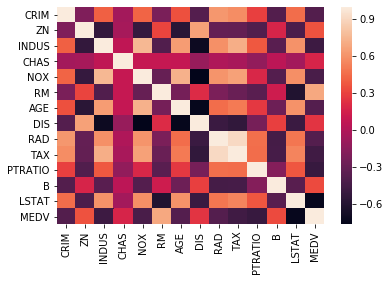

In [23]:
sns.heatmap(temp_df.corr());

I should have pobably chosen a different set of factors that berret correlate to my target variable such as:
    - "LSTAT" (-0.737663)
    - "RM" (0.695360)
    - "PTRATIO" (-0.507787)
    - "INDUS" (-0.483725) 


+ LSTAT:    % lower status of the population
+ RM:       average number of rooms per dwelling
+ PTRATIO:  pupil-teacher ratio by town
+ INDUS:    proportion of non-retail business acres per town

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# based on the 4 measures that most correlate. (ABOVE)
X2 = X[["LSTAT","RM","PTRATIO","INDUS"]]

### **Model with 70-30**

In [27]:
X70_train, X30_test, y70_train, y30_test = train_test_split(X2,y,test_size=30, train_size= 70 ,random_state=24) 
#NOT 42, just to annoy you guys :P 

**Initialize**

In [28]:
linreg2 = LinearRegression()

**Fitting the model**

In [29]:
model70_30 = linreg2.fit(X70_train,y70_train)

**Inspecting**

In [30]:
coefficients2 = linreg2.coef_
print("Linear Regression COEFFICIENTS")
print(coefficients2)

Linear Regression COEFFICIENTS
[[-0.24826193  5.34687538 -1.34728542 -0.09954324]]


In [31]:
intercept2 = linreg2.intercept_
print("Linear Regression INTERCEPT")
print(intercept2)

Linear Regression INTERCEPT
[17.45053032]


In [32]:
y_pred2 = linreg2.predict(X30_test) #predicting on the TEST data ! 

In [33]:
mse2 = mean_squared_error(y_pred2, y30_test)
rmse2 = np.sqrt(mse2)

print('Mean squared error: %f'% mse2)
print('Root mean squared error: %f'% rmse2)

Mean squared error: 56.593029
Root mean squared error: 7.522834


In [34]:
model70_30.score(X30_test, y30_test)

0.09704158128462104

### **Model with 90-10**

In [35]:
X90_train, X10_test, y90_train, y10_test = train_test_split(X2,y,test_size=10, train_size= 90 ,random_state=24) #NOT 42, just to annoy you guys :P 

**Initialize**

In [36]:
linreg3 = LinearRegression()

**Fitting the model**

In [37]:
model90_10 = linreg3.fit(X90_train,y90_train)

**Inspecting**

In [38]:
coefficients3 = linreg3.coef_
print("Linear Regression COEFFICIENTS")
print(coefficients3)

Linear Regression COEFFICIENTS
[[-0.35496189  4.66524922 -1.35508434 -0.01133824]]


In [40]:
intercept3 = linreg3.intercept_
print("Linear Regression INTERCEPT")
print(intercept3)

Linear Regression INTERCEPT
[22.27691774]


In [39]:
y_pred3 = linreg3.predict(X10_test) #predicting on the TEST data ! 

In [41]:
mse3 = mean_squared_error(y_pred3, y10_test)
rmse3 = np.sqrt(mse3)

print('Mean squared error: %f'% mse3)
print('Root mean squared error: %f'% rmse3)

Mean squared error: 117.161292
Root mean squared error: 10.824107


In [42]:
model90_10.score(X10_test, y10_test)

-0.0918184568537792

### Comparing both models 

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [47]:
from sklearn import model_selection

In [69]:
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [68]:
X2.iloc[train_index]

,LSTAT,RM,PTRATIO,INDUS
0,4.98,6.575,15.3,2.31
1,9.14,6.421,17.8,7.07
2,4.03,7.185,17.8,7.07
4,5.33,7.147,18.7,2.18
5,5.21,6.430,18.7,2.18
6,12.43,6.012,15.2,7.87
8,29.93,5.631,15.2,7.87
9,17.10,6.004,15.2,7.87
11,13.27,6.009,15.2,7.87
12,15.71,5.889,15.2,7.87


In [71]:
linregkf = LinearRegression()
mse_compare = []
rmse_compare = []
scores_compare = []

for n in range(5,11):
    kf = model_selection.KFold(n_splits=n, shuffle=True)
    kf.split(X2,y)
    
    X_train, X_test = np.array(X2.iloc[train_index]).reshape(-1,1), np.array(X2.iloc[test_index]).reshape(-1,1)
    #X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    linregkf.fit(X_train,y_train)
    y_pred_kf = linregkf.predict(X_test)
    
    mse_kf = mean_squared_error(y_pred_kf, y_test)
    rmse_kf = np.sqrt(mse_kf)
    score_kf = linregkf.score(y_pred_kf, y_test)
    
    mse_compare.append(mse_kf)
    rmse_compare (rmse_kf)
    scores_compare.append(score_kf)
    
    print("\nNumber of splits:",n, "\nScore:", score_kf, "\n")
    

ValueError: Found input variables with inconsistent numbers of samples: [1620, 405]

In [78]:
# I got the error above and couldn´t solve it. 
# instead, researching I found the cross_val_score which essentially does what I was intending to do.

In [86]:
from sklearn.model_selection import cross_val_score, cross_validate,

In [83]:
linregkf = LinearRegression()

scores = []
avg_scores = []

for n in range(5,11):
    scores.append(cross_val_score(linregkf,X2,y, cv = n))
    avg_scores.append(cross_val_score(linregkf,X2,y, cv = n).mean())

In [84]:
scores

[array([ 0.72738696,  0.70240317,  0.54242767,  0.15053352, -0.11775201]),
 array([ 0.71235875,  0.70824764,  0.50507743,  0.71664658, -0.0119341 ,
         0.05647687]),
 array([ 0.73131524,  0.65012358,  0.57256464,  0.60858099,  0.25570083,
        -0.15213022,  0.27370477]),
 array([ 0.75939364,  0.61034738,  0.67826647,  0.61518915,  0.70260846,
        -0.30401301, -0.81490593,  0.28931779]),
 array([ 0.75508033,  0.66438045,  0.70818793,  0.45657467,  0.68427552,
         0.58534465, -0.06501066, -0.94716384,  0.3201021 ]),
 array([ 0.76283488,  0.64503995, -0.58959275,  0.55381153,  0.6005876 ,
         0.65748101,  0.00559449,  0.02921866, -1.20250812,  0.46737651])]

In [85]:
avg_scores

[0.4009998623847066,
 0.44781219526866484,
 0.4199799747539271,
 0.31702549344517644,
 0.3513079052726408,
 0.19298437674554275]

It seems like the more folds the lower my score. 

In [107]:
cross_validate(linregkf,X2,y, cv = 5, scoring = ["explained_variance", "r2"] )

{'fit_time': array([0.00375605, 0.00356984, 0.00353312, 0.00343394, 0.00398231]),
 'score_time': array([0.00286913, 0.00468802, 0.00386405, 0.00445175, 0.00436568]),
 'test_explained_variance': array([0.76132978, 0.70346185, 0.61996773, 0.15328271, 0.10203759]),
 'test_r2': array([ 0.72738696,  0.70240317,  0.54242767,  0.15053352, -0.11775201])}

# KNN Practice

In [ ]:
# Read the iris data into a DataFrame, take it from the notebook where we saw KNN
#create 
#col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


In [ ]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [ ]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES


## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

### Create your target vector "y"
This will be the species type.

### Make Use of Train-Test-Split
Split your data in to train and test sets.

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

### Create a Model With Five Neighbors. Did it Improve?

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores
